In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

import sys
sys.path.append('./module')
from utils import log_diff, log_diff_inv, load_fx_data
from kalman_filters import ExtendedKalmanFilter as EnKF

In [6]:
df_dict = load_fx_data(['USD_JPY'])

In [312]:
import numpy as np
from numpy import sqrt, trace, zeros, identity, exp, random
from numpy.random import multivariate_normal, choice
from numpy.linalg import inv

class ExtendedKalmanFilter:
    def __init__(self, M, H, G, Q, R, y, x_0, P_0, dt=0.05, delta=1e-3, var3d=False, alpha=1):
        self.M = M
        self.G = G
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.dt = dt
        self.dim_x = x_0.shape[0]
        self.P = P_0
        self.trP = []
        self.x_a = x_0
        self.x = []
        self.delta = delta
        self.var3d = var3d
        #self.A = alpha*identity(dim_x) #　加法的誤差共分散膨張
        self.alpha = alpha # 1以上
        
  # 逐次推定を行う
    def forward_estimation(self):
        count = 0
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        # self.P = self.P + self.A # 加法的誤差共分散膨張, P = self.P + self.Aとするとうまくいかない． 乗法的方法に変更
        self.P = self.alpha*self.P # 乗法的
        P = self.P

        H = self.H.copy()
                
        # Kalman gain 
        K = P@H.T@inv(H@P@H.T + self.R)
        
        # 誤差共分散更新
        if not self.var3d:
            self.P -= K@H@P

        # x 更新
        self.x_a = self.x_f + K@(y_obs - H@self.x_f)

        # 更新した値を保存
        # self.x.append(self.x_a)
        self.trP.append(sqrt(trace(self.P)/40)) # traceを正規化して保存

    # 予報/時間発展
    def _forecast(self, log=False):
        x_a = self.x_a; dt = self.dt; M = self.M; N = self.dim_x
        
        # 予報
        self.x_f = self.M(x_a, dt) + self._generate_noise() #保存しておく
        
        if not self.var3d:
            # 線形化， dtを大きくするとうまくいかなくなる
            JM = zeros((N, N))
            for j in range(N):
                dx = self.delta*identity(N)[:, j]
                JM[:, j] = (M(x_a + dx, dt) - self.x_f)/self.delta # ここでJM[:, j] = (M(x_a + dx, dt) - self.M(x_a, dt))/self.deltaとするとすごく遅くなる

            self.P = JM@self.P@JM.T + self.G@self.Q@(self.G.T)

        if True or log:
            self.x.append(self.x_f)
            # print(self._generate_noise())
    
    def _generate_noise(self):
        return self.G@multivariate_normal(zeros(self.Q.shape[0]), self.Q)
    
    # 追加の推定(観測値なし)
    def additional_forecast(self, step):
        for _ in range(step):
            self._forecast(log=True)

In [322]:
# ハイパーパラメータの設定
std = 0.00001
sd_sys_t = std*10 #システムノイズにおけるトレンド成分の標準偏差の推定値
sd_sys_s = std #システムノイズにおける周期成分(季節成分)の標準偏差の推定値
sd_obs = np.std(y) #観測ノイズの標準偏差の推定値
tdim = 2 #トレンドモデルの次元
period = 5 #周期の推定値
pdim = period - 1 #周期変動モデルの次元

#トレンドモデル
F1 = np.array([[2, -1], [1, 0]])
G1 = np.array([[1], [0]])

#トレンドモデルの観測モデル
H1 = np.array([[1, 0]])

#周期変動モデル
F2 = np.block([[-1*np.ones((1, pdim))], [np.eye(pdim-1), np.zeros((pdim-1, 1))]])
# F2 = np.array([
#     [-1, -1, -1, -1, -1, -1],
#     [+1,  0,  0,  0,  0,  0],
#     [ 0, +1,  0,  0,  0,  0],
#     [ 0,  0, +1,  0,  0,  0],
#     [ 0,  0,  0, +1,  0,  0],
#     [ 0,  0,  0,  0, +1,  0]])
G2 = np.zeros((pdim, 1))
G2[0,0] = 1

#周期変動モデルの観測モデル
H2 = np.zeros((1, pdim))
H2[0,0] = 1

#モデル全体
#システムモデル
F = np.block([[F1, np.zeros((tdim, pdim))], [np.zeros((pdim,tdim)), F2]])
M = lambda x,t: F@x
G = np.block([[G1, np.zeros((tdim,1))], [np.zeros((pdim,1)), G2]])
Q = np.array([[sd_sys_t**2, 0], [0, sd_sys_s**2]])
#観測モデル
H = np.block([[H1, H2]])
R = np.array([[sd_obs**2]])

#状態変数などの定義
# #データに関係ない初期値を格納するため N+1 個の配列を確保
dim = tdim + pdim #状態変数の次元

In [323]:
# (self, M, H, G, Q, R, y, x_0, P_0, dt=0.05, delta=1e-3, var3d=False, alpha=1):
y = df_dict['USD_JPY']['Close_ask'].values
x0 = np.ones(dim)*100
P_0 = np.identity(dim)*25
enkf = ExtendedKalmanFilter(M, H, G, Q, R, y[:-100], x0, P_0)
enkf.forward_estimation()

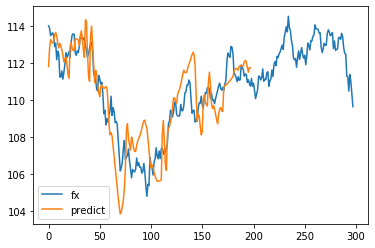

In [324]:
start = 1000
plt.plot(y[start:], label='fx')
# predict = (H@np.array(enkf.x).T).T
predict = np.array(enkf.x)[:, 0]
plt.plot(predict[start:], label='predict')
plt.legend()

In [306]:
enkf.additional_forecast(100)

[-0.00074239  0.         -0.00090985  0.          0.          0.        ]
[-3.47232654e-04  0.00000000e+00  5.48605963e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-0.00032875  0.         -0.00027487  0.          0.          0.        ]
[-0.00023058  0.         -0.00020309  0.          0.          0.        ]
[-0.00038065  0.          0.00029677  0.          0.          0.        ]
[0.00042399 0.         0.00024863 0.         0.         0.        ]
[ 2.49296026e-04  0.00000000e+00 -6.44955999e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-0.00052277  0.         -0.00015904  0.          0.          0.        ]
[-0.00024289  0.         -0.00018991  0.          0.          0.        ]
[0.00015511 0.         0.00040039 0.         0.         0.        ]
[-0.00047477  0.         -0.00057532  0.          0.          0.        ]
[0.00013002 0.         0.00043633 0.         0.         0.        ]
[-0.00088921  0.         -0.0004474   0.          0.          0.        ]
[-0.00

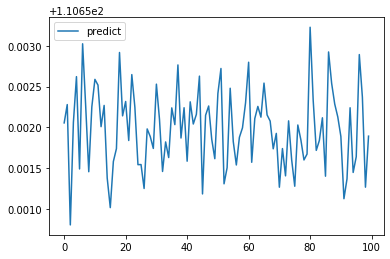

In [309]:
# plt.plot(y[start:], label='fx')
# predict = (H@np.array(enkf.x).T).T
predict = np.array(enkf.x)[:, 0]
plt.plot(predict[-100:], label='predict')
plt.legend()

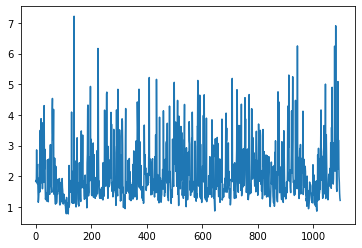

In [285]:
plt.plot(enkf.trP[100:])